# Prepping data for EOF calculation

Extract fields of annual
- SST: globally
- (upper OHC (0-50m))
- MLD (Mar for NH): NA only


In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36411,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:46597,Total threads: 4
Dashboard: /proxy/45369/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:34343,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
#expt_CM2_1   = 'bz687'

In [4]:
# # OM2 database
# session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
# expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
# expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [14]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

In [4]:
# Plotting info
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

ft_size = 16
plt.rcParams.update({'font.size': ft_size})

### Mixed layer depth (March), North Atlanic

In [6]:
lon_slice = slice(-75,-7)
lat_slice = slice(25,70)

In [7]:
def get_mld(expt, session, start_time='0001-01-01', end_time='0002-12-31'):

    mld = cc.querying.getvar(expt, 'mld', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly')
    mld = mld.sel(time=slice(start_time,end_time)).sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
    # Select March
    mld = mld.groupby('time.month')[3]
    
    return mld.compute()


In [10]:
%%time
test = get_mld(expt_CM2_025, session_CM2, start_time='0001-01-01', end_time='0499-12-31')

CPU times: user 14.8 s, sys: 1.61 s, total: 16.4 s
Wall time: 31.7 s


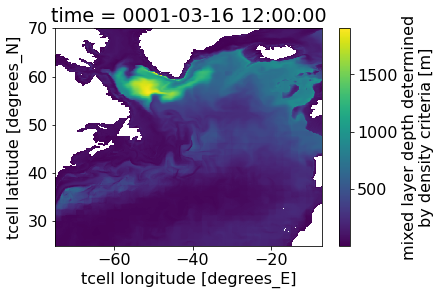

In [12]:
test[0,...].plot()

In [11]:
test

<xarray.DataArray 'mld' (time: 499, yt_ocean: 290, xt_ocean: 272)>
array([[[ 20.822058,  23.244005,  20.259674, ...,        nan,
                nan,        nan],
        [ 22.989069,  20.919662,  20.211634, ...,        nan,
                nan,        nan],
        [ 20.518944,  20.589262,  20.399527, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,  98.11502 ,
         152.64838 , 273.25223 ],
        [       nan,        nan,        nan, ...,  53.89107 ,
          73.59656 , 127.502975],
        [       nan,        nan,        nan, ...,  38.420284,
          45.396915,  56.565815]],

       [[ 94.56129 ,  86.15499 ,  69.05311 , ...,        nan,
                nan,        nan],
        [ 91.3942  ,  66.79916 ,  32.32277 , ...,        nan,
                nan,        nan],
        [ 50.922993,  32.001297,  45.341034, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 456.68622 ,
         500.48563 , 530.9017  ],
        [       nan,        nan,        nan, ..., 446.12363 ,
         478.53073 , 517.93805 ],
        [       nan,        nan,        nan, ..., 428.70828 ,
         459.00366 , 499.291   ]],

       [[ 45.67421 ,  45.069767,  41.821026, ...,        nan,
                nan,        nan],
        [ 41.296783,  50.204906,  44.123737, ...,        nan,
                nan,        nan],
        [ 60.63307 ,  57.1537  ,  44.049786, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 214.08398 ,
         395.53375 , 595.21967 ],
        [       nan,        nan,        nan, ..., 201.49419 ,
         360.73358 , 543.0365  ],
        [       nan,        nan,        nan, ..., 166.70888 ,
         325.39267 , 492.40842 ]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -74.88 -74.62 -74.38 ... -7.625 -7.375 -7.125
  * yt_ocean  (yt_ocean) float64 25.04 25.26 25.49 25.72 ... 69.78 69.88 69.99
  * time      (time) object 0001-03-16 12:00:00 ... 0499-03-16 12:00:00
Attributes:
    long_name:      mixed layer depth determined by density criteria
    units:          m
    valid_range:    [      0. 1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    ncfiles:        ['/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/o...
    contact:        Martin Dix
    email:          martin.dix@csiro.au
    created:        2021-11-30
    description:    ACCESS-CM2 with n96 atmosphere coupled to COSIMA OM2 0.25...
    url:            https://code.metoffice.gov.uk/svn/roses-u/c/j/8/7/7/trunk

In [15]:
# Save data
test.to_netcdf(path_to_data + 'mld_Mar_NA.nc')

### SST, annual mean, globally

In [40]:
def get_sst(expt, session, start_time='0001-01-01', end_time='0002-12-31'):

    sst = cc.querying.getvar(expt, 'temp', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly') - 273.15
    sst = sst.sel(time=slice(start_time,end_time)).sel(st_ocean=0, method='nearest')
    #.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
    # Select March
    sst = sst.resample(time='Y').mean()
    
    return sst.compute()

In [48]:
%%time
sst_400_499 = get_sst(expt_CM2_025, session_CM2, start_time='0400-01-01', end_time='0499-12-31')

CPU times: user 2min 25s, sys: 10.4 s, total: 2min 36s
Wall time: 3min 23s


In [50]:
sst_all = xr.concat([sst_0_99, sst_100_199, sst_200_299, sst_300_399, sst_400_499], dim="time")

In [52]:
sst_all.to_netcdf(path_to_data + 'SST_global_annual.nc')